In [91]:
%matplotlib inline

from __future__ import division, print_function

import pandas
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
from  matplotlib import rc
from scipy.optimize import curve_fit
from scipy import stats
# from scipy.stats import chisqprob, chi2
# from scipy.constants import k as k_boltzman, e as e_charge

import os
import sys
from datetime import datetime
import cPickle as pickle
from collections import namedtuple, OrderedDict
import itertools as it
from functools import partial
from PIL import Image

from uncertainties import ufloat
from uncertainties import unumpy
from uncertainties.umath import *

In [92]:
rc('font', family='Arial') #Plotowanie polskich liter

In [93]:
dir_path = 'data'

data_labels = {
    'natAzotOdKv' : (u'Natężenie lasera azotowego', u'w funkcji napięcia zasilania'),
    'natAzotOdHz' : (u'Natężenie lasera azotowego', u'w funkcji częstości repetycji'),
    'natAzotOdHg' : (u'Natężenie lasera azotowego', u'w funkcji ciśnienia azotu'),
    'natBarw'     : (u'Natężenie lasera barwnikowego', u'w funkcji napięcia zasilania'),
    'nat2Harm'    : (u'Natężenie drugiej harmonicznej', u'w funkcji napięcia zasilania'),
    'nat2HarmOdDwojYellow': (u'Natężenie drugiej harmonicznej', u'w funkcji skrecenia kryształu dwójłomnego'),
    'nat2HarmOdDwoj'      : (u'Natężenie drugiej harmonicznej', u'w funkcji skrecenia kryształu dwójłomnego'),
    'nat2HarmOdFresnela'  : (u'Natężenie drugiej harmonicznej', u'w funkcji kąta skręcenia płaszczyzny polaryzacji'),    
}

data_labels = {key : value + (os.path.join(dir_path, key + '.csv'),) for key, value in data_labels.iteritems()}

In [94]:
Labels = namedtuple('Labels', ['x', 'y', 'label_y', 'label_x', 'key'])
Labels._title = lambda self: self.label_y + ' ' + self.label_x

Data = namedtuple('Data', ['x', 'y', 'labels'])
Data._names = lambda self: (self.labels.x, self.labels.y)

In [95]:
unv  = unumpy.nominal_values
ustd = unumpy.std_devs

uplot      = lambda x, y, *args, **kwargs: plt.errorbar(x=unv(x), y=unv(y), xerr=ustd(x), yerr=ustd(y), *args, **kwargs)
ucurve_fit = lambda x, y, *args, **kwargs: curve_fit(xdata=unv(x), ydata=unv(y), sigma=ustd(y), *args, **kwargs)
# def ucurve_fit(x, y, *args, **kwargs):
#     popt, pcov = curve_fit(xdata=unv(x), ydata=unv(y), yerr=sigma(y), *args, **kwargs)
#     return unumpy.uarray(popt, np.sqrt(np.diag(pcov)))

myplot      = lambda xy,  *args, **kwargs:      uplot(xy.x,xy.y, *args, **kwargs)
mycurve_fit = lambda xy,  *args, **kwargs: ucurve_fit(xy.x,xy.y, *args, **kwargs)

In [96]:
def crop_image(filepath):
    image=Image.open(filepath)
    image.load()
    image_data = np.asarray(image)
    image_data_bw = image_data.min(axis=2)
    non_empty_columns = np.where(image_data_bw.min(axis=0)<255)[0]
    non_empty_rows = np.where(image_data_bw.min(axis=1)<255)[0]
    cropBox = (min(non_empty_rows), max(non_empty_rows), min(non_empty_columns), max(non_empty_columns))
    image_data_new = image_data[cropBox[0]:cropBox[1]+1, cropBox[2]:cropBox[3]+1 , :]
    new_image = Image.fromarray(image_data_new)
    new_image.save(filepath)
    # http://stackoverflow.com/questions/14211340/automatically-cropping-an-image-with-python-pil

def _Data_curve_fit(self, *args, **kwargs):
    popt, pcov = ucurve_fit(self.x, self.y, *args, **kwargs)
    return unumpy.uarray(popt, np.sqrt(np.diag(pcov)))

def _Data_plot(self, loc = 4, title = False, fun = None, tight = True, show = False, crop = True, rc = [5,4], rc_multi = 1.5, dpi = 140, *args, **kwargs):
    plt.clf()
    myplot(self, label = self.labels.label_y, *args, **kwargs) 
    plt.xlabel(self.labels.x)
    plt.ylabel(self.labels.y)
    if title:
        plt.title(self.labels._title())
    
    plt.grid()
    plt.rcParams['figure.figsize'] = np.array(rc)*rc_multi   
    if fun != None:
        fun()
    plt.legend(loc = loc)
    if tight:
        plt.tight_layout()     
    if show:
        plt.show()
    else:       
        filepath = os.path.join('plots',self.labels.key + '.png')
        plt.savefig(filepath, dpi = 140) 
        if crop:
            crop_image(filepath)            
        
def _Data_print(self, latex = False):    
    if latex:
        for x,y in zip(self.x,self.y):
            print('{:L} : {:L}'.format(x,y))    
    else:
        for x,y in zip(self.x,self.y):
            print('{} : {}'.format(x,y))    
        
Data._plot = _Data_plot
Data._curve_fit = _Data_curve_fit
Data._print = _Data_print

In [97]:
def AnalyzeCSV(key, value, verbose = True):
    df = pandas.read_csv(value[2], sep =';', decimal = ',', encoding ='cp1250')
    if verbose:
#         print df
        df.plot(x=0, y=0, xerr='xerr', yerr='yerr') 
#         help(df.plot)
    data = df.as_matrix().T
    columns = list(df)
    if verbose:
        print(columns[0], columns[1])
    single_column_zeros = np.zeros(data[0].shape)
                                     
    labels = Labels(x = columns[0], y = columns[1], label_x = value[1], label_y = value[0], key = key)
    data = Data(x = unumpy.uarray(data[0], data[2]), y = unumpy.uarray(data[1], data[3]), labels = labels)
    return data

AnalyzeCSVwrapper = lambda key: AnalyzeCSV(key, data_labels[key], False)

myData = {key: AnalyzeCSV(key, value, False) for key, value in data_labels.iteritems()}
# map(partial(print, end=" "), myData['natBarw'].labels)

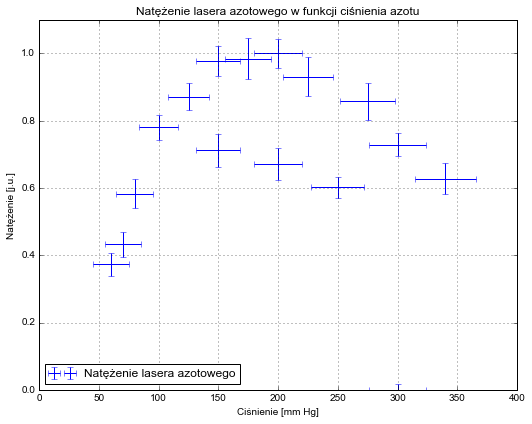

In [118]:
normalize = lambda y: y/y[y.argmax()].n

# Uśrednienie pomiarów
myData['natAzotOdHg'] = AnalyzeCSVwrapper('natAzotOdHg')
x, y = myData['natAzotOdHg'].x, myData['natAzotOdHg'].y
do_usrednienia = [100,150,200,125,250,300]
for i in do_usrednienia:
    i_m = i - 10
    i_p = i + 10
    if i in [125,150,300,200]:
        warunek = (x>=i_m) & (x<=i_p) & (y>=750)
    else:
        warunek = (x>=i_m) & (x<=i_p)
    mean = y[warunek].mean()
    val_x = x[np.where(warunek)[0][0]]
    y = np.delete(y, np.where(warunek)[0])
    x = np.delete(x, np.where(warunek)[0])
    y = np.append(y, mean)
    x = np.append(x, val_x)

myData['natAzotOdHg'] = myData['natAzotOdHg']._replace(x=x, y=y)
# myData['natAzotOdHg']._plot(title = True,show=True, fun = lambda: plt.ylim(0,1200) ,fmt='None')

myData['natAzotOdHg'] = myData['natAzotOdHg']._replace(y=normalize(y))
myData['natAzotOdHg']._plot(title = True,show=False, fun = lambda: plt.ylim(0,1.1), loc = 3 ,fmt='None')

# nalezy zaznaczyc jeszcze 4 punkty na kolorowo

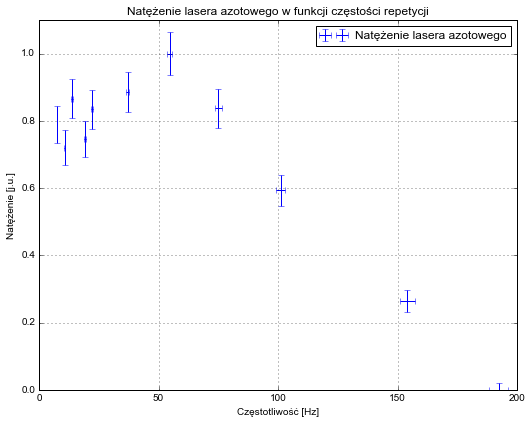

In [120]:
# Ustawienie jednostek umownych dla natAzotOdHg
myData['natAzotOdHz'] = AnalyzeCSVwrapper('natAzotOdHz')
myData['natAzotOdHz'] = myData['natAzotOdHz']._replace(y=normalize(myData['natAzotOdHz'].y))
myData['natAzotOdHz']._plot(title = True, fun = lambda: plt.ylim(0,1.1), loc = 1, fmt='None')
# niepewnosc z ostatniego zostala przeniesiona na pozostale

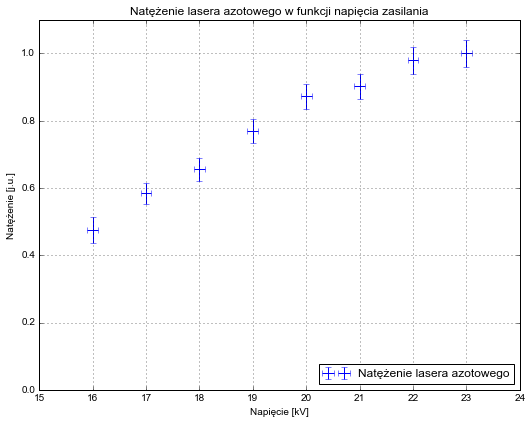

In [122]:
# Ustawienie jednostek umownych dla natAzotOdKv
myData['natAzotOdKv'] = AnalyzeCSVwrapper('natAzotOdKv')
myData['natAzotOdKv'] = myData['natAzotOdKv']._replace(y=normalize(myData['natAzotOdKv'].y))
myData['natAzotOdKv']._plot(title = True, fun = lambda: plt.ylim(0,1.1), loc = 4, fmt='None')
# niepewnosc z ostatniego zostala przeniesiona na pozostale

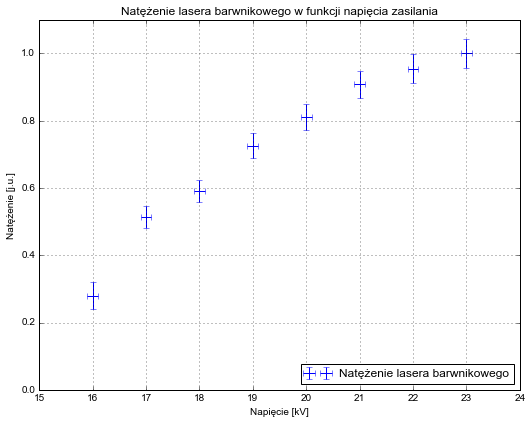

In [124]:
# Ustawienie jednostek umownych dla natBarwnikowego w kV
myData['natBarw'] = AnalyzeCSVwrapper('natBarw')
myData['natBarw'] = myData['natBarw']._replace(y=normalize(myData['natBarw'].y))
myData['natBarw']._plot(title = True, fun = lambda: plt.ylim(0,1.1), fmt='None')
# niepewnosc z ostatniego zostala przeniesiona na pozostale

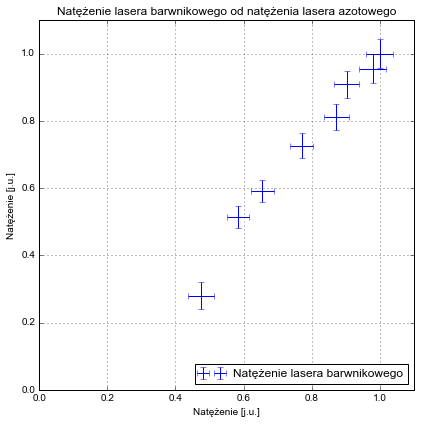

In [144]:
# Labels = namedtuple('Labels', ['x', 'y', 'label_y', 'label_x', 'key'])
# Data = namedtuple('Data', ['x', 'y', 'labels'])

def joinDataByX(datax, datay, key):
    mergedDataLabel = Labels(x=datax.labels.y, y=datay.labels.y, label_x=datax.labels.label_y, label_y=datay.labels.label_y, key=key)
    return Data(datax.y, datay.y, mergedDataLabel)

def fun_01(func=None):    
    plt.ylim(0,1.1)
    plt.xlim(0,1.1) 

def fun_01_outer(func=None):
    def fun_01_inside():
        fun_01()      
        if func != None:
            func()
            
    return fun_01_inside
  
myTitle = u'Natężenie lasera barwnikowego od natężenia lasera azotowego'
myData['natBarwOdAzot'] = joinDataByX(myData['natAzotOdKv'], myData['natBarw'],'natBarwOdAzot')
myData['natBarwOdAzot']._plot(title = True, show=False, fun = fun_01_outer(lambda:plt.title(myTitle)), rc =[4,4], fmt='None')

myData['nat2HarmOdBarw'] = joinDataByX(myData['natBarw'], myData['nat2Harm'],'nat2HarmOdBarw')
myData['nat2HarmOdBarw']._plot(title = True, show=False, fun = fun_01, rc =[4,4], fmt='None')

[0.3597363459765888+/-0.07591025348321112
 0.6444859495028196+/-0.0632363580404707] [0.9376907396871316+/-0.02635211505559262]


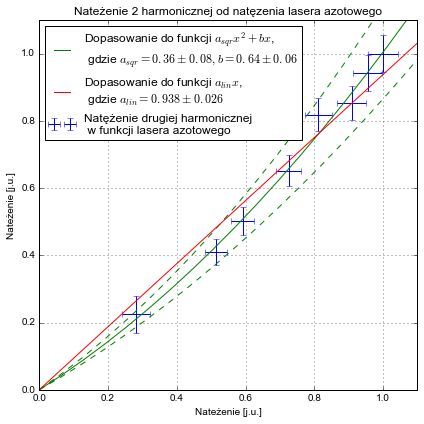

In [143]:
# ?curve_fit
# def ucurve_fit(x, y, *args, **kwargs):
#     popt, pcov = curve_fit(xdata=unv(x), ydata=unv(y), yerr=sigma(y), *args, **kwargs)
#     return unumpy.uarray(popt, np.sqrt(np.diag(pcov)))
fsqr = lambda x, a, b: a*x**2 + b*x
flin = lambda x, al  : al*x
p1    = myData['nat2HarmOdBarw']._curve_fit(p0 = (0.5, 0.5), f=fsqr)
p1lin = myData['nat2HarmOdBarw']._curve_fit(p0 = 1,          f=flin)
print(p1, p1lin)
a, b= unv(p1)
ap, bp = unv(p1)+ustd(p1)
am, bm = unv(p1)-ustd(p1)
alin = unv(p1lin)
alinp = unv(p1lin)+ustd(p1lin)
alinm = unv(p1lin)-ustd(p1lin)


# print(unv(myData['nat2harmOdBarw'].x))
# print(partial(fsqr, a=a, b=b)(unv(myData['nat2harmOdBarw'].x)))

# @fun_01
# def plot_fit():
#     plt.plot(unv(myData['nat2harmOdBarw'].x), partial(fsqr, a=a, b=b)(unv(myData['nat2harmOdBarw'].x)),label ='dopasowanie')
x = np.linspace(0,1.2,20)

label_data = u'Natężenie drugiej harmonicznej \n w funkcji lasera azotowego'
label_dop  = u'Dopasowanie do funkcji $a_{{sqr}}  x^2 + b x$,\n gdzie $a_{{sqr}}={:L}, b={:L}$'.format(*p1)
label_dop_lin  = u'Dopasowanie do funkcji $a_{{lin}}x$,\n gdzie $a_{{lin}}={:L}$'.format(*p1lin)
uplot(x=myData['nat2HarmOdBarw'].x, y=myData['nat2HarmOdBarw'].y, fmt='None', label = label_data)
plt.plot(x, partial(fsqr,  a=a, b=b)(x), 'g-',label = label_dop)
plt.plot(x, partial(fsqr,  a=ap, b=bp)(x),'g--')
plt.plot(x, partial(fsqr,  a=am, b=bm)(x),'g--')
plt.plot(x, partial(flin,  al=alin)(x), 'r-', label = label_dop_lin)
# plt.plot(x, partial(flin,  al=alinp)(x),'r--')
# plt.plot(x, partial(flin,  al=alinm)(x),'r--')
plt.ylim(0,1.1)
plt.xlim(0,1.1)
plt.legend(loc=2)
plt.xlabel(u'Nateżenie [j.u.]')
plt.ylabel(u'Nateżenie [j.u.]')
plt.title(u'Nateżenie 2 harmonicznej od natęzenia lasera azotowego')
plt.grid()
plt.tight_layout() 
# plt.show()
filepath = os.path.join('plots', 'nat2HarmOdBarwDopasowania' + '.png')
plt.savefig(filepath, dpi = 140) 
crop_image(filepath)
    
# myData['nat2harmOdBarw']._plot(title = True, show=True, fun = plot_fit, rc =[6,6], fmt='None')

In [130]:
# return x, (y+-yerr), xerr, popt, np.sqrt(np.diag(pcov)), lambda x : foo(x, popt[0], popt[1])
def chi2f(fit):
    
    x = unv(fit[0])
    y = unv(fit[1])
    yerr = ustd(fit[1])
    popt = fit[2]
    foo = fit[3]
#     print y
#     print foo(x)
#     print yerr
    suma = np.sum(((y - foo(x)) / yerr)**2)
    d = len(x) - len(popt)
    print('{:>5.2f} / {} = {:.3f}'.format(suma, d, suma / d))
    return suma / d, d

fit1 =  myData['nat2HarmOdBarw'].x, myData['nat2HarmOdBarw'].y, p1lin, partial(flin,  al=alin)
fit2 =  myData['nat2HarmOdBarw'].x, myData['nat2HarmOdBarw'].y, p1, partial(fsqr,  a=a, b=b)

print('lin')
chi1 = chi2f(fit1)
print('prawd {:0.3f}'.format(stats.chisqprob(chi1[0],chi1[1])))
print(1 - stats.chi2.cdf(chi1[0]*chi1[1],chi1[1]))

print('\nsqr')
chi2 = chi2f(fit2)
print('prawd {:0.3f}'.format(stats.chisqprob(chi2[0],chi2[1])))
print(1 - stats.chi2.cdf(chi2[0]*chi2[1],chi2[1]))

lin
 9.18 / 7 = 1.312
prawd 0.988
0.239728539021

sqr
 1.94 / 6 = 0.323
prawd 0.999
0.925463240327


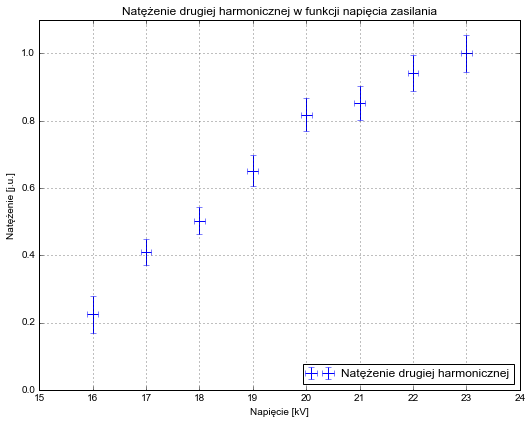

In [132]:
# Ustawienie jednostek umownych dla nat2Harm w kV
myData['nat2Harm'] = AnalyzeCSVwrapper('nat2Harm')
myData['nat2Harm'] = myData['nat2Harm']._replace(y=normalize(myData['nat2Harm'].y))
myData['nat2Harm']._plot(title = True, fun = lambda: plt.ylim(0,1.1), fmt='None')
# niepewnosc z ostatniego zostala przeniesiona na pozostale

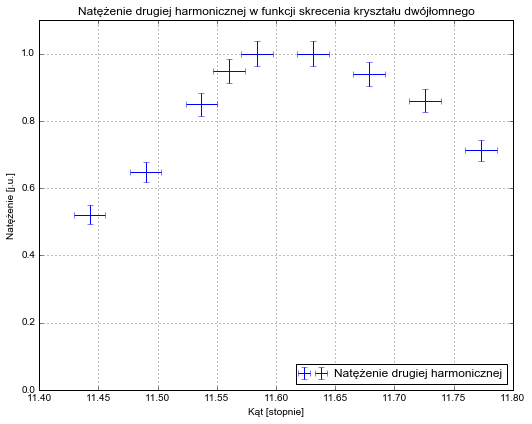

In [134]:
# Ustawienie jednostek umownych dla nat2Harm w kV
ramie = ufloat(62,0.05)

myData['nat2HarmOdDwoj'] = AnalyzeCSVwrapper('nat2HarmOdDwoj')
myData['nat2HarmOdDwoj'] = myData['nat2HarmOdDwoj']._replace(y=normalize(myData['nat2HarmOdDwoj'].y))
myData['nat2HarmOdDwoj'] = myData['nat2HarmOdDwoj']._replace(x=unumpy.degrees(unumpy.arcsin(myData['nat2HarmOdDwoj'].x/ramie)))
myData['nat2HarmOdDwoj'] = myData['nat2HarmOdDwoj']._replace(labels = myData['nat2HarmOdDwoj'].labels._replace(x=u"Kąt [stopnie]"))
myData['nat2HarmOdDwoj']._plot(title = True, fun = lambda: plt.ylim(0,1.1), fmt='None')
# niepewnosc z ostatniego zostala przeniesiona na pozostale

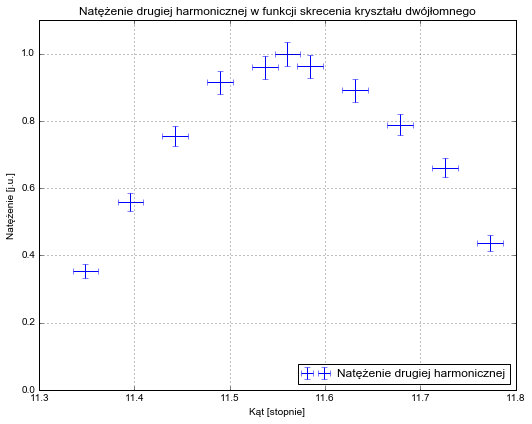

In [136]:
# Ustawienie jednostek umownych dla nat2Harm w kV
myData['nat2HarmOdDwojYellow'] = AnalyzeCSVwrapper('nat2HarmOdDwojYellow')
myData['nat2HarmOdDwojYellow'] = myData['nat2HarmOdDwojYellow']._replace(y=normalize(myData['nat2HarmOdDwojYellow'].y))
myData['nat2HarmOdDwojYellow'] = myData['nat2HarmOdDwojYellow']._replace(x=unumpy.degrees(unumpy.arcsin(myData['nat2HarmOdDwojYellow'].x/ramie)))
myData['nat2HarmOdDwojYellow'] = myData['nat2HarmOdDwojYellow']._replace(labels = myData['nat2HarmOdDwojYellow'].labels._replace(x=u"Kąt [stopnie]"))
myData['nat2HarmOdDwojYellow']._plot(title = True, fun = lambda: plt.ylim(0,1.1), fmt='None')
# niepewnosc z ostatniego zostala przeniesiona na pozostale

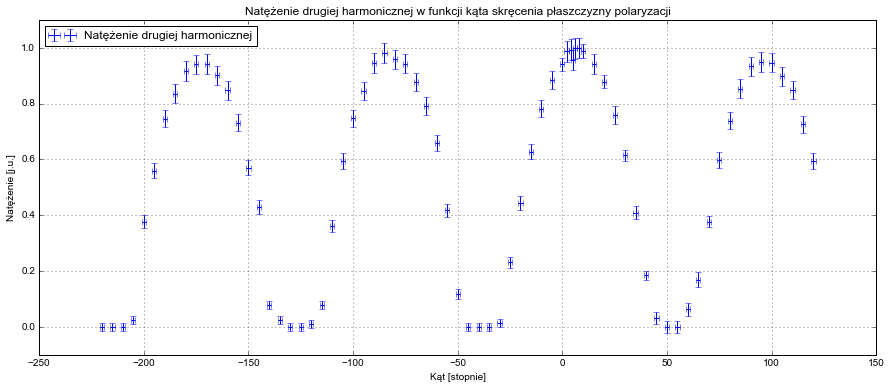

In [138]:
# Ustawienie jednostek umownych dla nat2Harm w kV
myData['nat2HarmOdFresnela'] = AnalyzeCSVwrapper('nat2HarmOdFresnela')

x, y = myData['nat2HarmOdFresnela'].x, myData['nat2HarmOdFresnela'].y
do_usrednienia = [0,10,20,30,40,70]
for i in do_usrednienia:
    delta = 0.5
    i_m = i - delta
    i_p = i + delta
    warunek = (x>=i_m) & (x<=i_p)
    mean = y[warunek].mean()
    val_x = x[np.where(warunek)[0][0]]
    y = np.delete(y, np.where(warunek)[0])
    x = np.delete(x, np.where(warunek)[0])
    y = np.append(y, mean)
    x = np.append(x, val_x)

myData['nat2HarmOdFresnela'] = myData['nat2HarmOdFresnela']._replace(x=x, y=y)
myData['nat2HarmOdFresnela'] = myData['nat2HarmOdFresnela']._replace(y=normalize(myData['nat2HarmOdFresnela'].y))
myData['nat2HarmOdFresnela']._plot(title = True, fun = lambda: plt.ylim(-0.1,1.1), loc = 2,rc=[10,4], tight = False, fmt='None')


# niepewnosc z ostatniego zostala przeniesiona na pozostale

In [109]:
kat_dopasowania = {
    'zielony' : ufloat(10.97, 0.05),
    'zolty' : ufloat(12.30, 0.05),
    'czerwony' : ufloat(14.60, 0.05)
}
ramie2 = ufloat(62, 0.1)

kat_dopasowania_wkacie = {key : degrees(asin(value/ramie2)) for key, value in kat_dopasowania.iteritems()}
for key, value in kat_dopasowania_wkacie.iteritems():
    print('{}: {:L}'.format(key, value))
    
print('{:L}'.format((degrees(asin(ufloat(14.60, 0.03)/ramie2))-degrees(asin(ufloat(10.97, 0.03)/ramie2)))/360*100))

zielony: 10.19 \pm 0.05
czerwony: 13.62 \pm 0.05
zolty: 11.44 \pm 0.05
0.952 \pm 0.011


In [110]:
myData["nat2HarmOdDwojYellow"]._print()

11.348+/-0.013 : 0.353+/-0.021
11.396+/-0.013 : 0.559+/-0.026
11.443+/-0.013 : 0.754+/-0.030
11.490+/-0.013 : 0.914+/-0.034
11.537+/-0.013 : 0.959+/-0.035
11.561+/-0.013 : 1.00+/-0.04
11.584+/-0.013 : 0.962+/-0.035
11.631+/-0.013 : 0.890+/-0.033
11.678+/-0.013 : 0.788+/-0.031
11.726+/-0.013 : 0.660+/-0.028
11.773+/-0.013 : 0.436+/-0.023
